# Outlier Detection

In [678]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from collections import deque
import sys

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib

from sklearn.metrics import (
                            roc_curve,
                            auc, accuracy_score,
                            precision_score, 
                            recall_score,
                            f1_score
                            )
import tensorflow as tf
from pickle import dump
import yaml

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

In [679]:
# 1. Función para cargar y limpiar los datos
def cargar_y_limpiar_datos(file_path):
    data = pd.read_excel(file_path, header=0)
    data = data.drop(['Total general (Número de pasajeros)'], axis=1)
    data['Día'] = pd.to_datetime(data['Día'], dayfirst=True)
    data.columns = [str(col) if isinstance(col, datetime.time) else col for col in data.columns]
    horas = [col for col in data.columns if ':' in col]
    return data, horas

# 2. Función para filtrar datos de una línea específica
def filtrar_por_linea(data, linea_servicio='línea a'):
    return data[data['Línea de Servicio'].str.lower() == linea_servicio]

# 3. Función para generar el DataFrame completo de fechas y agregar columnas adicionales
def generar_dataframe_completo(data_linea_a, start, end):
    fechas_2023 = pd.DataFrame({'Día': pd.date_range(start=start, end=end)})
    data_linea_a_full = pd.merge(fechas_2023, data_linea_a, on='Día', how='left')
    data_linea_a_full['Día de la Semana'] = data_linea_a_full['Día'].dt.day_name()
    data_linea_a_full.columns = [str(col) if isinstance(col, datetime.time) else col for col in data_linea_a_full.columns]
    return data_linea_a_full

# 4. Función para calcular el promedio estacional por día de la semana
def calcular_promedio_estacional(data, horas):
    return data.groupby('Día de la Semana')[horas].median().round(0)

# 5. Función para rellenar los valores faltantes
def rellenar_faltantes(data, promedio_estacional, horas):
    # Asegúrate de que 'Día' esté presente en el DataFrame
    if 'Día de la Semana' not in data.columns:
        raise ValueError("El DataFrame 'data' debe contener una columna llamada 'Día' que indique el día de la semana.")

    # Itera sobre las horas para rellenar los valores faltantes
    for hora in horas:
        if hora in data.columns:
            # Rellena los valores faltantes según el promedio estacional
            data[hora] = data.apply(
                lambda row: promedio_estacional.loc[row['Día de la Semana'], hora] if pd.isnull(row[hora]) else row[hora], axis=1
            )
        else:
            print(f"La columna {hora} no existe en el DataFrame, omitiendo...")
        
    data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill') 

    return data

# 6. Función para eliminar tendencia y estacionalidad
def eliminar_tendencia_estacionalidad(data, horas):
    descomposiciones = {}
    for hora in horas:
        serie = data.set_index('Día')[hora].dropna()
        try:
            descomp_aditiva = seasonal_decompose(serie, model='additive', period=7)
            residuo_aditivo = descomp_aditiva.resid.dropna()
            mse_aditivo = np.mean(np.square(residuo_aditivo))
        except Exception as e:
            print(f"Error en descomposición aditiva para {hora}: {e}")
            mse_aditivo = np.inf
        try:
            descomp_multiplicativa = seasonal_decompose(serie, model='multiplicative', period=7)
            residuo_multiplicativa = descomp_multiplicativa.resid.dropna()
            mse_multiplicativa = np.mean(np.square(residuo_multiplicativa))
        except Exception as e:
            print(f"Error en descomposición multiplicativa para {hora}: {e}")
            mse_multiplicativa = np.inf

        if mse_aditivo < mse_multiplicativa:
            print(f"Usando descomposición aditiva para {hora}")
            descomposiciones[hora] = descomp_aditiva
        else:
            print(f"Usando descomposición multiplicativa para {hora}")
            descomposiciones[hora] = descomp_multiplicativa
    return descomposiciones

# 7. Función para detectar outliers usando el método IQR
def detectar_outliers_en_residuos(descomposiciones, umbral=1.5, data=None):
    outliers_matrix = pd.DataFrame(0, index=descomposiciones[list(descomposiciones.keys())[0]].resid.dropna().index, columns=descomposiciones.keys())
    for hora, descomposicion in descomposiciones.items():
        if hora != list(descomposiciones.keys())[-1]:
            residuo = pd.DataFrame(descomposicion.resid.dropna()).merge(data, on='Día', how='left')
            residuo.index = outliers_matrix.index
            for day in data['Día de la Semana'].unique():
                residuo_estacional = residuo[residuo['Día de la Semana'] == day][hora]
                Q1 = residuo_estacional.quantile(0.25)
                Q3 = residuo_estacional.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - umbral * IQR
                upper_bound = Q3 + umbral * IQR
                outliers = ((residuo_estacional < lower_bound) | (residuo_estacional > upper_bound)).astype(int)
                outliers_matrix.loc[outliers.index, hora] = outliers

    # Columna que cuenta el número total de outliers por día
    outliers_matrix['Total_Outliers'] = outliers_matrix.sum(axis=1)
    
    # Columna que indica si existe al menos un outlier en alguna de las horas (1 si al menos uno, 0 si no) -> si hay mas de 1 (¿Una linea?, ¿Una hora influye en las demas?)
    outliers_matrix['Any_Outlier'] = (outliers_matrix['Total_Outliers'] > 2).astype(int)        
    
    return outliers_matrix

# 8. Función para graficar la proporción de días con outliers
def graficar_proporcion_outliers(data):
    proporcion_outliers = data['Hay_Outlier'].value_counts(normalize=True)
    plt.figure(figsize=(6,4))
    proporcion_outliers.plot(kind='bar', color=['blue', 'orange'], grid=True)
    plt.title('Proporción de días con al menos un outlier')
    plt.xlabel('Hay Outlier')
    plt.ylabel('Proporción')
    plt.xticks(ticks=[0, 1], labels=['No hay outliers', 'Hay al menos un outlier'], rotation=0)
    plt.ylim(0, 1)
    plt.show()

# Función para entrenar el autoencoder -> se usa tanh ya que las columnas de hora mapeadas con sen(x) estan en el rango [-1,1]
# def entrenar_autoencoder(train_data_afluencia, train_data_horas, test_data_afluencia, test_data_horas, input_dim):
#     # Input layers
#     input_afluencia = Input(shape=(input_dim,))
#     input_horas = Input(shape=(train_data_horas.shape[1],))  # Metadata de las horas en dominio seno

#     # Concatenar ambas entradas
#     concatenated = Concatenate()([input_afluencia, input_horas])

#     # Encoder
#     # encoded = Dense(16, activation='tanh')(concatenated)
#     encoded = Dense(8, activation='tanh')(concatenated)
#     encoded = Dense(4, activation='tanh')(encoded)
    
#     # Decoder: Solo decodificamos las afluencias
#     decoded = Dense(8, activation='tanh')(encoded)
#     decoded = Dense(16, activation='tanh')(decoded)
#     decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Salida para reconstruir solo las afluencias

#     # Construimos el modelo con dos entradas
#     autoencoder = Model(inputs=[input_afluencia, input_horas], outputs=decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')

#     # Early stopping
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     # Entrenamiento
#     history = autoencoder.fit([train_data_afluencia, train_data_horas], train_data_afluencia,
#                               epochs=100, batch_size=512,
#                               validation_data=([test_data_afluencia, test_data_horas], test_data_afluencia),
#                               callbacks=[early_stopping],
#                               verbose=1)
    
#     return autoencoder, history

# Función para entrenar el autoencoder con menos neuronas y regularización
def entrenar_autoencoder(train_data_afluencia, train_data_horas, test_data_afluencia, test_data_horas, input_dim):
    # Input layers
    input_afluencia = Input(shape=(input_dim,))
    input_horas = Input(shape=(train_data_horas.shape[1],))  # Metadata de las horas en dominio seno

    # Concatenar ambas entradas
    concatenated = Concatenate()([input_afluencia, input_horas])

    # Encoder
    encoded = Dense(8, activation='tanh', kernel_regularizer=l2(0.001))(concatenated)  # Menos neuronas y regularización L2
    encoded = Dropout(0.2)(encoded)  # Dropout del 20%
    encoded = Dense(4, activation='tanh', kernel_regularizer=l2(0.001))(encoded)  # Menos neuronas y regularización L2
    encoded = Dropout(0.2)(encoded)

    # Decoder: Solo decodificamos las afluencias
    decoded = Dense(4, activation='tanh', kernel_regularizer=l2(0.001))(encoded)  # Menos neuronas y regularización L2
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(8, activation='tanh', kernel_regularizer=l2(0.001))(decoded)  # Menos neuronas y regularización L2
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Salida para reconstruir solo las afluencias

    # Construimos el modelo con dos entradas
    autoencoder = Model(inputs=[input_afluencia, input_horas], outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenamiento
    history = autoencoder.fit([train_data_afluencia, train_data_horas], train_data_afluencia,
                              epochs=100, batch_size=512,
                              validation_data=([test_data_afluencia, test_data_horas], test_data_afluencia),
                              callbacks=[early_stopping],
                              verbose=1)

    return autoencoder, history

# 10. Función para graficar la curva de entrenamiento
def graficar_curva_entrenamiento(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Curva de Error durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MAE)')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'./results/train_curve.png')
    plt.show()

# 11. Función para evaluar el modelo
def evaluar_autoencoder(autoencoder, test_data_afluencia_normalized, test_data_horas_seno, test_data, scaler, outlier_labels, umbral):
    # Predicción usando ambas entradas (afluencias y horas en seno)
    predicted_normalized = autoencoder.predict([test_data_afluencia_normalized, test_data_horas_seno])
    
    # Invertir la normalización para obtener los valores originales de las afluencias
    predicted = scaler.inverse_transform(predicted_normalized)
    test_data_scaled = scaler.inverse_transform(test_data)
    
    # Calcular los errores de reconstrucción
    errors = np.mean(np.abs(test_data_scaled - predicted), axis=1)

    # Calcular el umbral basado en los errores de las instancias normales
    errors_normales = errors[outlier_labels == 0]
    threshold = errors_normales.mean() + umbral * errors_normales.std()

    return threshold, errors


In [715]:
def graficar_casos_outliers_vs_normales(autoencoder, scaler, data_linea_a_full_outliers, horas_outliers_columns, horas_sin_columns, n=0):
    # Selección de un caso sin outliers y un caso con outliers
    sin_outliers = data_linea_a_full_outliers[data_linea_a_full_outliers['Any_Outlier_outlier'] == 0].iloc[n]
    con_outliers = data_linea_a_full_outliers[data_linea_a_full_outliers['Any_Outlier_outlier'] == 1].iloc[n]

    # Convertir las columnas de las horas de datos reales y reconstruidos a arrays
    # Datos reales y reconstruidos para un caso sin outliers
    real_sin_outliers = sin_outliers[horas_outliers_columns].values
    horas_sin_outliers = sin_outliers[horas_sin_columns].values  # Agregamos la codificación de las horas en seno
    
    # Asegurar que ambas entradas sean arrays 2D con la misma forma
    real_sin_outliers = real_sin_outliers.reshape(1, -1)
    horas_sin_outliers = horas_sin_outliers.reshape(1, -1)

    # Reescalar los datos reales para el caso sin outliers
    real_sin_outliers_rescaled = scaler.inverse_transform(real_sin_outliers)

    # Hacer predicción usando ambas entradas: afluencia y horas en seno
    reconstruido_sin_outliers = scaler.inverse_transform(
        autoencoder.predict([real_sin_outliers, horas_sin_outliers])
    )[0]

    # Datos reales y reconstruidos para un caso con outliers
    real_con_outliers = con_outliers[horas_outliers_columns].values
    horas_con_outliers = con_outliers[horas_sin_columns].values  # Agregamos la codificación de las horas en seno
    
    # Asegurar que ambas entradas sean arrays 2D con la misma forma
    real_con_outliers = real_con_outliers.reshape(1, -1)
    horas_con_outliers = horas_con_outliers.reshape(1, -1)

    # Reescalar los datos reales para el caso con outliers
    real_con_outliers_rescaled = scaler.inverse_transform(real_con_outliers)
    
    # Hacer predicción usando ambas entradas: afluencia y horas en seno
    reconstruido_con_outliers = scaler.inverse_transform(
        autoencoder.predict([real_con_outliers, horas_con_outliers])
    )[0]

    # 2. Creación de los subplots
    plt.figure(figsize=(14, 6))

    # 2.1 Subplot para caso sin outliers
    plt.subplot(1, 2, 1)
    plt.plot(horas_outliers_columns, real_sin_outliers_rescaled[0], label='Real', color='blue', marker='o')
    plt.plot(horas_outliers_columns, reconstruido_sin_outliers, label='Reconstruido', color='green', marker='x')
    plt.title('Caso sin Outliers')
    plt.xlabel('Hora')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotar los xticks para que se vean mejor
    plt.ylabel('Afluencia de Pasajeros')
    plt.legend()

    # 2.2 Subplot para caso con outliers
    plt.subplot(1, 2, 2)
    plt.plot(horas_outliers_columns, real_con_outliers_rescaled[0], label='Real', color='blue', marker='o')
    plt.plot(horas_outliers_columns, reconstruido_con_outliers, label='Reconstruido', color='green', marker='x')

    plt.title('Caso con Outliers')
    plt.xlabel('Hora')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotar los xticks para que se vean mejor
    plt.ylabel('Afluencia de Pasajeros')
    plt.legend()

    # Mostrar los subplots
    plt.tight_layout()
    plt.show()

In [681]:
# 1. Cargar y limpiar los datos para el año 2019
file_path_2019 = './data/Afluencia_Metro_2019.xlsx'
data_2019, horas_2019 = cargar_y_limpiar_datos(file_path_2019)

# 1. Cargar y limpiar los datos para el año 2020
file_path_2020 = './data/Afluencia_Metro_2020.xlsx'
data_2020, horas_2020 = cargar_y_limpiar_datos(file_path_2020)

# 1. Cargar y limpiar los datos para el año 2021
file_path_2021 = './data/Afluencia_Metro_2021.xlsx'
data_2021, horas_2021 = cargar_y_limpiar_datos(file_path_2021)

# 1. Cargar y limpiar los datos para el año 2022
file_path_2022 = './data/Afluencia_Metro_2022.xlsx'
data_2022, horas_2022 = cargar_y_limpiar_datos(file_path_2022)

# 1. Cargar y limpiar los datos para el año 2023
file_path_2023 = './data/Afluencia_Metro_2023.xlsx'
data_2023, horas_2023 = cargar_y_limpiar_datos(file_path_2023)

# 1. Cargar y limpiar los datos para el año 2024
file_path_2024 = './data/Afluencia_Metro_2024.xlsx'
data_2024, horas = cargar_y_limpiar_datos(file_path_2024)

data_2024.head()

,Día,Línea de Servicio,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,2024-01-01,LÍNEA 1,180.0,858.0,886.0,721.0,659.0,820.0,952.0,1083.0,...,1418.0,1563.0,1734.0,2108.0,2352.0,1903.0,1676.0,1132.0,139.0,NaN
1,2024-01-01,LÍNEA 2,1.0,149.0,143.0,74.0,100.0,135.0,116.0,225.0,...,198.0,188.0,277.0,291.0,284.0,212.0,152.0,100.0,9.0,NaN
2,2024-01-01,LÍNEA A,1460.0,5488.0,5769.0,4752.0,3993.0,4512.0,5551.0,7197.0,...,10362.0,10666.0,12998.0,15376.0,16932.0,14537.0,11750.0,7729.0,664.0,NaN
3,2024-01-01,LÍNEA B,231.0,718.0,826.0,672.0,641.0,818.0,1060.0,1398.0,...,1741.0,1956.0,2228.0,2587.0,2749.0,2043.0,1302.0,893.0,85.0,NaN
4,2024-01-01,LÍNEA H,NaN,NaN,NaN,NaN,NaN,50.0,62.0,71.0,...,76.0,72.0,93.0,83.0,113.0,80.0,39.0,25.0,4.0,NaN


In [682]:
# 2. Filtrar los datos para la LÍNEA A en 2019
data_linea_a_2019 = filtrar_por_linea(data_2019)

# 2. Filtrar los datos para la LÍNEA A en 2020
data_linea_a_2020 = filtrar_por_linea(data_2020)

# 2. Filtrar los datos para la LÍNEA A en 2021
data_linea_a_2021 = filtrar_por_linea(data_2021)

# 2. Filtrar los datos para la LÍNEA A en 2022
data_linea_a_2022 = filtrar_por_linea(data_2022)

# 2. Filtrar los datos para la LÍNEA A en 2023
data_linea_a_2023 = filtrar_por_linea(data_2023)

# 2. Filtrar los datos para la LÍNEA A en 2024
data_linea_a_2024 = filtrar_por_linea(data_2024)
data_linea_a_2024['Línea de Servicio'].unique()

array(['LÍNEA A'], dtype=object)

In [683]:
len(data_linea_a_2019), len(data_linea_a_2020), len(data_linea_a_2021), len(data_linea_a_2022), len(data_linea_a_2023), len(data_linea_a_2024)

(365, 363, 365, 365, 365, 182)

In [684]:
# 2. Concatenar todos los dataframes de la Línea A
data_linea_a_2019_2024 = pd.concat([
                                #  data_linea_a_2019, 
                                #  data_linea_a_2020, 
                                #  data_linea_a_2021,
                                 data_linea_a_2022, 
                                 data_linea_a_2023, 
                                 data_linea_a_2024])

# 2. Ordenar los datos por la columna "Día"
data_linea_a_2019_2024 = data_linea_a_2019_2024.sort_values(by='Día')

# Ver el resultado ordenado
data_linea_a_2019_2024.tail()

,Día,Línea de Servicio,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
2091,2024-06-26,LÍNEA A,15238.0,45356.0,62796.0,52262.0,32352.0,26201.0,23441.0,24246.0,...,32473.0,35169.0,58282.0,80773.0,55675.0,30928.0,19321.0,16018.0,8951.0,44.0
2103,2024-06-27,LÍNEA A,17084.0,46288.0,62100.0,50224.0,32028.0,26135.0,23820.0,23858.0,...,31068.0,35303.0,59648.0,78520.0,55109.0,30814.0,19517.0,15876.0,9274.0,31.0
2114,2024-06-28,LÍNEA A,16765.0,43698.0,59798.0,49654.0,32460.0,26416.0,24101.0,25259.0,...,36412.0,44445.0,70419.0,65670.0,44884.0,35527.0,21028.0,18347.0,11375.0,93.0
2125,2024-06-29,LÍNEA A,12847.0,28578.0,33924.0,32900.0,25049.0,23103.0,23456.0,28578.0,...,41297.0,37356.0,35155.0,33779.0,29973.0,24755.0,18110.0,15480.0,8659.0,76.0
2136,2024-06-30,LÍNEA A,3531.0,10458.0,12376.0,11964.0,12350.0,14245.0,16202.0,16875.0,...,24515.0,21120.0,22916.0,18167.0,21615.0,17869.0,15775.0,12401.0,1068.0,NaN


In [685]:
# 3. Generar el DataFrame completo de fechas y agregar columnas adicionales
data_linea_a_full = generar_dataframe_completo(data_linea_a_2019_2024, start='2022-01-01', end='2024-06-30') # -> Va hasta el 2023-06-30 -> ir hasta 2024-12-31 me ayuda a crear datos "normales"
data_linea_a_full.isna().sum()

Día                    0
Línea de Servicio      0
04:00:00               0
05:00:00               0
06:00:00               0
07:00:00               0
08:00:00               0
09:00:00               0
10:00:00               0
11:00:00               0
12:00:00               0
13:00:00               0
14:00:00               0
15:00:00               0
16:00:00               0
17:00:00               0
18:00:00               0
19:00:00               0
20:00:00               0
21:00:00               0
22:00:00               2
23:00:00             310
Día de la Semana       0
dtype: int64

In [686]:
# 4. Calcular el promedio estacional por día de la semana para rellenar faltantes
promedio_estacional = calcular_promedio_estacional(data_linea_a_full, horas)

# 5. Rellenar los valores faltantes en el DataFrame completo
data_linea_a_full = rellenar_faltantes(data_linea_a_full, promedio_estacional, horas)
data_linea_a_full.to_excel('results/full_2019_2024_data_linea_A_imputed.xlsx', index=False)

data_linea_a_full['Línea de Servicio'] = 'LINEA A' # Cambiar dependiendo de la linea

data_linea_a_full.isna().sum()

C:\Users\SEBASTIAN\AppData\Local\Temp\ipykernel_16272\1773314897.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Línea de Servicio'] = data['Línea de Servicio'].fillna(method='ffill')


Día                  0
Línea de Servicio    0
04:00:00             0
05:00:00             0
06:00:00             0
07:00:00             0
08:00:00             0
09:00:00             0
10:00:00             0
11:00:00             0
12:00:00             0
13:00:00             0
14:00:00             0
15:00:00             0
16:00:00             0
17:00:00             0
18:00:00             0
19:00:00             0
20:00:00             0
21:00:00             0
22:00:00             0
23:00:00             0
Día de la Semana     0
dtype: int64

In [687]:
len(horas)

20

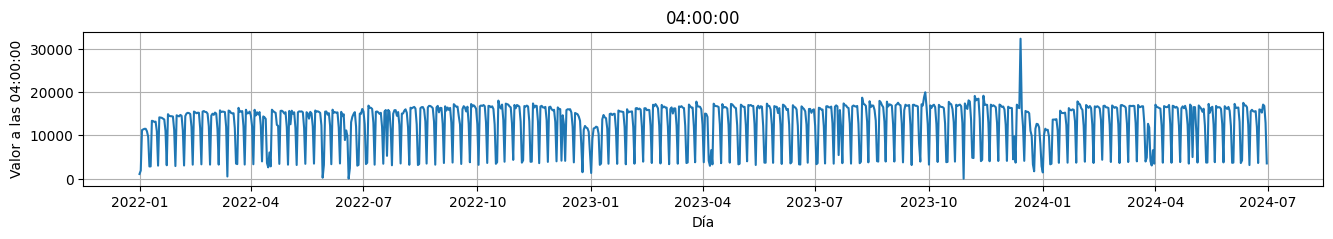

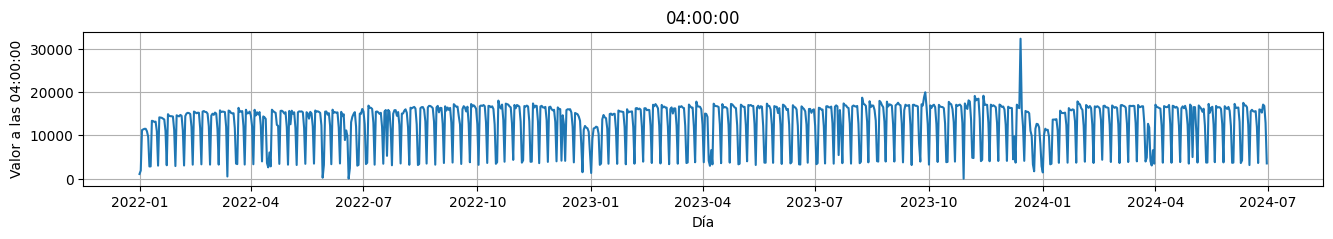

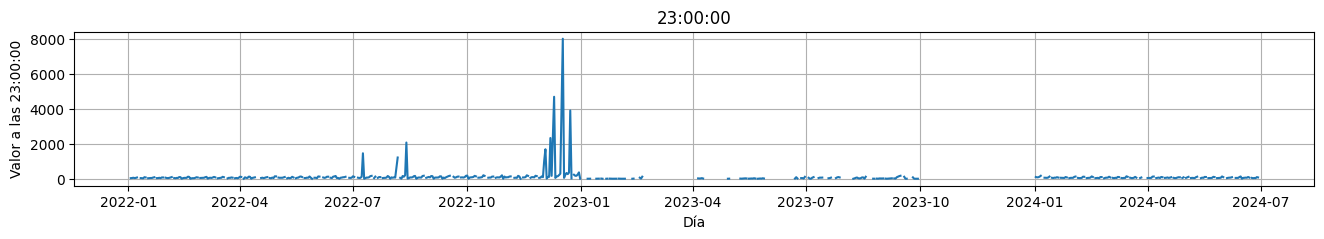

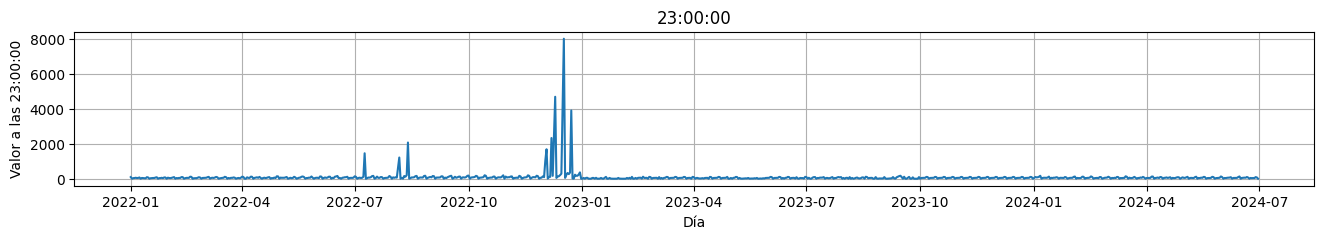

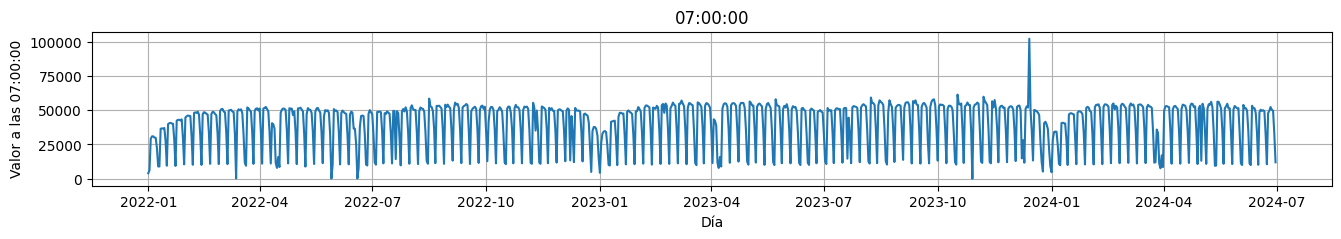

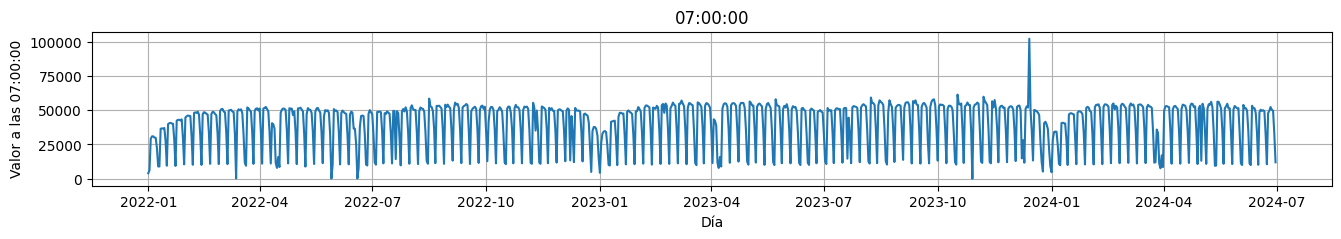

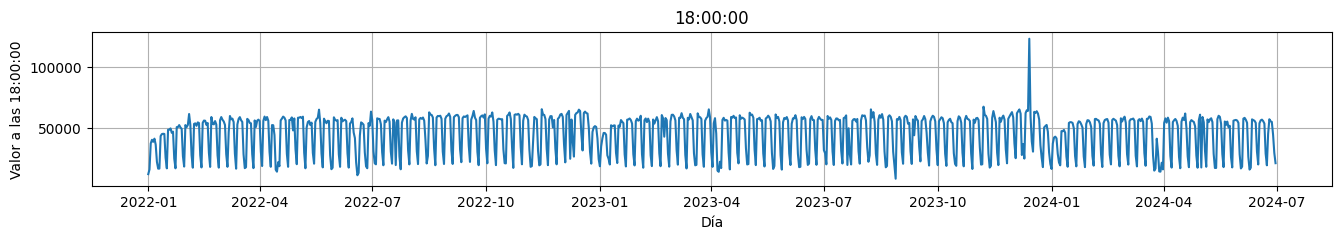

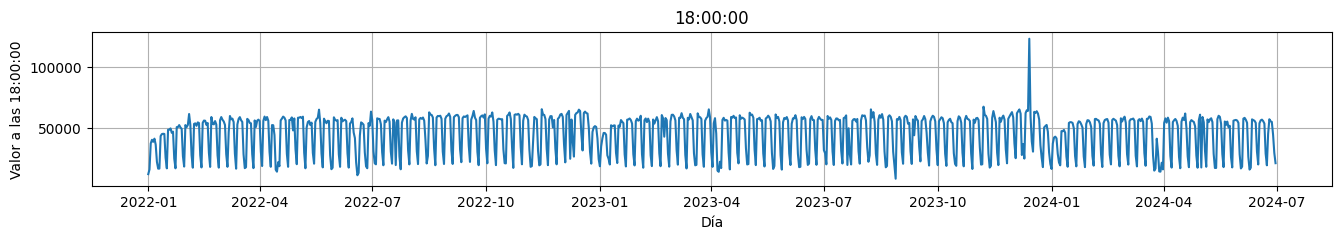

In [688]:
def plot_serie(df, hour, log_scale=False):
    plt.figure(figsize=(16, 2))
    plt.plot(df['Día'], df[hour])
    plt.title(hour)
    plt.xlabel('Día')
    plt.ylabel(f'Valor a las {hour}')
    if log_scale:
        plt.yscale('log')  # Aplica la escala logarítmica al eje y    
    plt.grid(True)
    plt.show()

hour = '04:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)    

hour = '23:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

hour = '07:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

hour = '18:00:00'
plot_serie(data_linea_a_2019_2024, hour, log_scale=False)
plot_serie(data_linea_a_full, hour, log_scale=False)

In [689]:
# 6. Eliminar tendencia y estacionalidad
descomposiciones_agrupadas = eliminar_tendencia_estacionalidad(data_linea_a_full, horas)

Usando descomposición multiplicativa para 04:00:00
Usando descomposición multiplicativa para 05:00:00
Usando descomposición multiplicativa para 06:00:00
Usando descomposición multiplicativa para 07:00:00
Usando descomposición multiplicativa para 08:00:00
Usando descomposición multiplicativa para 09:00:00
Usando descomposición multiplicativa para 10:00:00
Usando descomposición multiplicativa para 11:00:00
Usando descomposición multiplicativa para 12:00:00
Usando descomposición multiplicativa para 13:00:00
Usando descomposición multiplicativa para 14:00:00
Usando descomposición multiplicativa para 15:00:00
Usando descomposición multiplicativa para 16:00:00
Usando descomposición multiplicativa para 17:00:00
Usando descomposición multiplicativa para 18:00:00
Usando descomposición multiplicativa para 19:00:00
Usando descomposición multiplicativa para 20:00:00
Usando descomposición multiplicativa para 21:00:00
Usando descomposición multiplicativa para 22:00:00
Usando descomposición multiplic

In [690]:
# 7. Detectar outliers en los residuos de la serie
outliers_residuos_agrupados = detectar_outliers_en_residuos(descomposiciones_agrupadas, umbral=3, data=data_linea_a_full)

# 8. Alinear los outliers con los datos originales
outliers_residuos_agrupados_aligned = data_linea_a_full[['Día']].merge(outliers_residuos_agrupados, on='Día', how='left').fillna(0)
outliers_residuos_agrupados_aligned_all = data_linea_a_full.merge(outliers_residuos_agrupados.add_suffix('_outlier'), on='Día', how='left').fillna(0)

outliers_residuos_agrupados_aligned_all.to_excel('results/full_2019_2024_data_linea_A_outliers.xlsx', index=False)

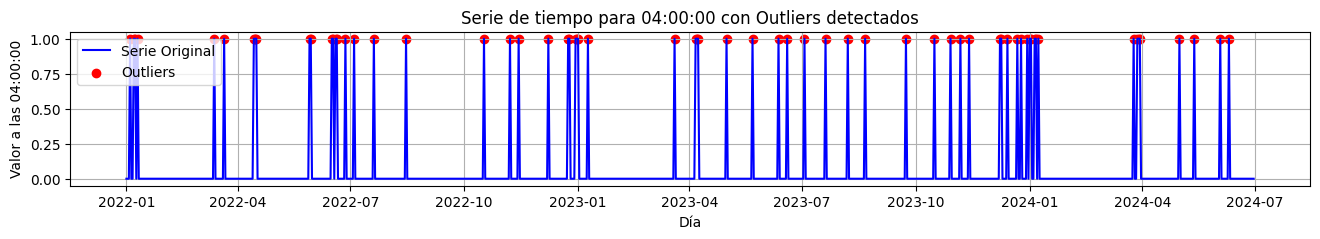

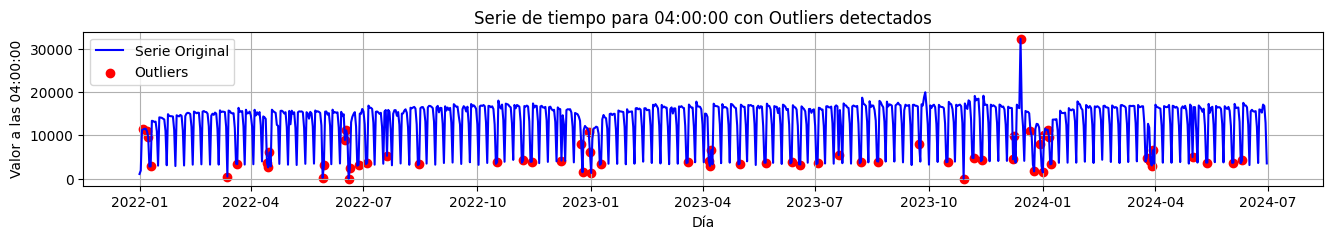

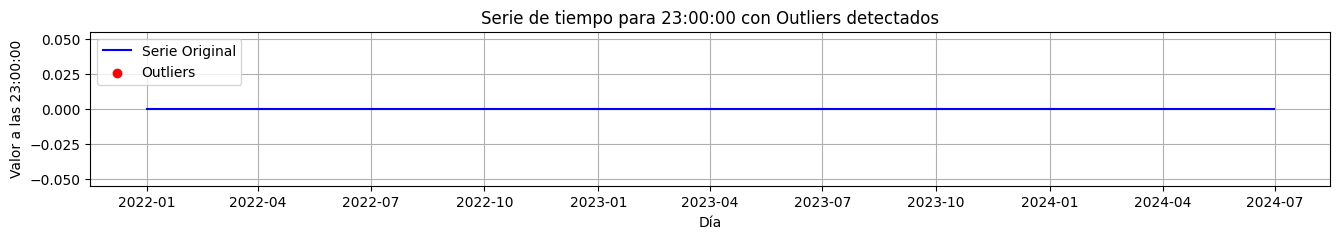

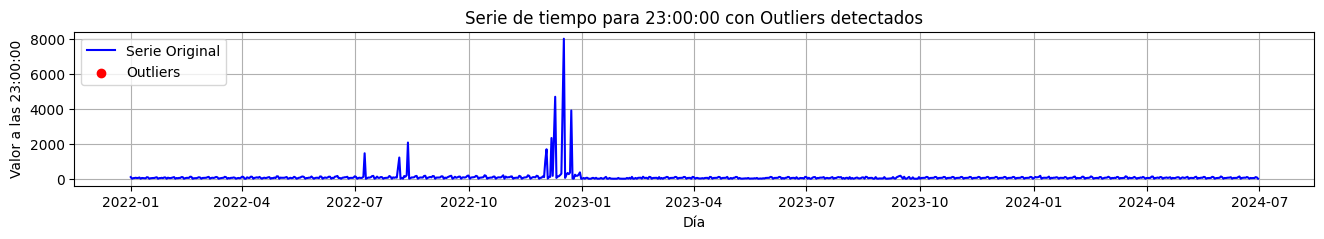

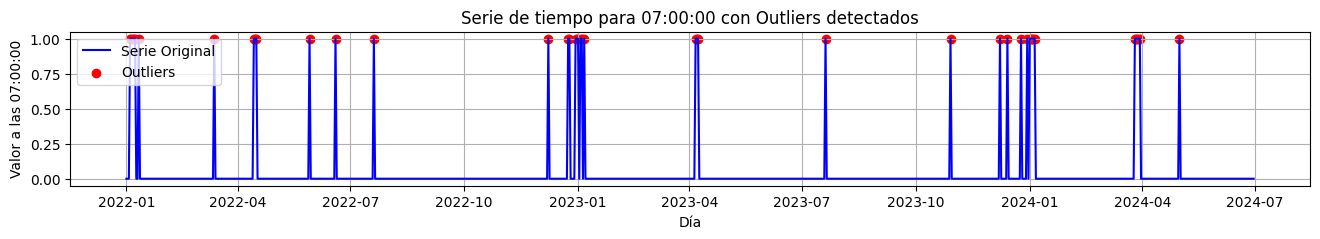

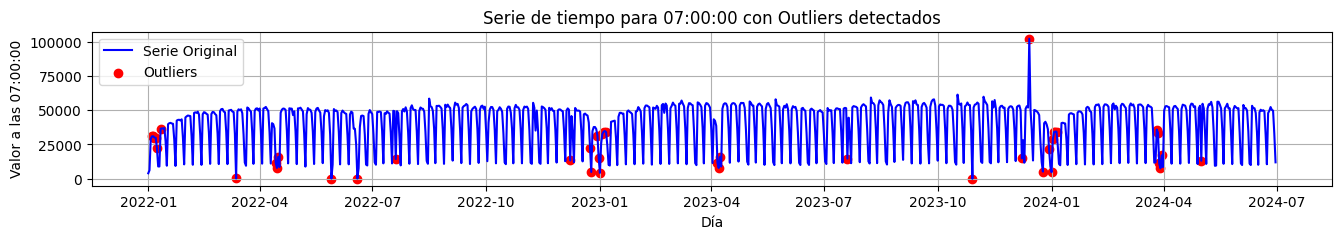

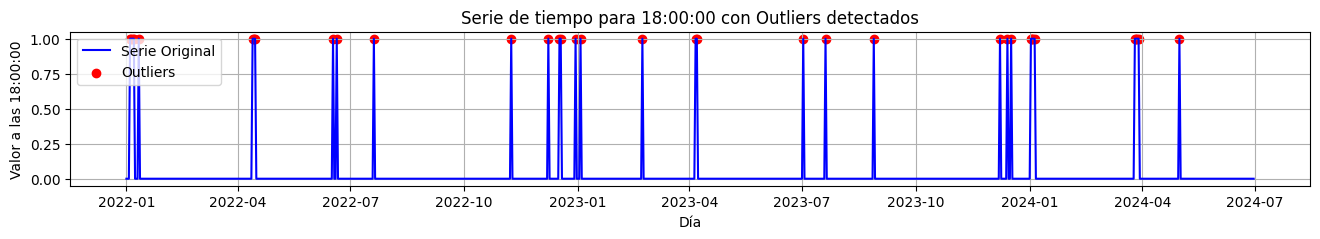

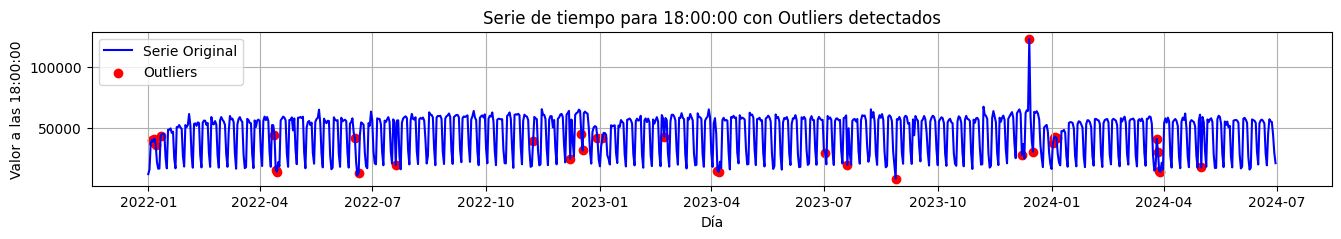

In [691]:
def plot_serie_con_outliers(df, hora, outliers_residuos):
    plt.figure(figsize=(16, 2))
    plt.plot(df['Día'], df[hora], label='Serie Original', color='blue')
    outliers = outliers_residuos[hora] == 1
    plt.scatter(df['Día'][outliers], df[hora][outliers], color='red', label='Outliers')
    plt.title(f'Serie de tiempo para {hora} con Outliers detectados')
    plt.xlabel('Día')
    plt.ylabel(f'Valor a las {hora}')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

hour = '04:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

#TODO: Se omite esta hora de la busqueda de ouliers por su gran cantidad de datos imputados y su baja afluencia.
hour = '23:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '07:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

hour = '18:00:00'
plot_serie_con_outliers(outliers_residuos_agrupados_aligned, hour, outliers_residuos_agrupados_aligned)
plot_serie_con_outliers(data_linea_a_full, hour, outliers_residuos_agrupados_aligned)

Any_Outlier_outlier
0.0                    822
1.0                     90
Name: count, dtype: int64

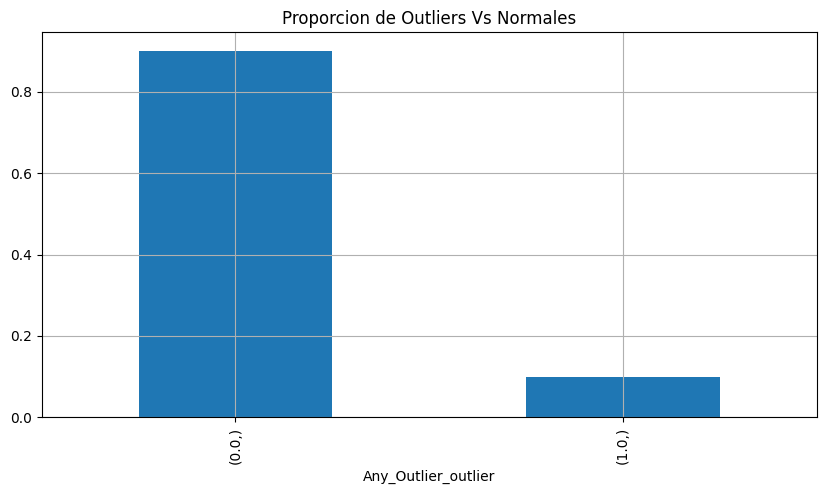

In [692]:
outliers_residuos_agrupados_aligned_all[['Any_Outlier_outlier']].value_counts(normalize=True).plot(kind='bar', grid=True, figsize=(10,5), title="Proporcion de Outliers Vs Normales")
outliers_residuos_agrupados_aligned_all[['Any_Outlier_outlier']].value_counts()

In [693]:
# Función para codificar las horas en función seno
def codificar_horas_seno(horas):
    """
    Codifica las horas en formato entero en una función seno para capturar su naturaleza cíclica.
    """
    return np.sin(2 * np.pi * horas / 24)

# Función para procesar y escalar las afluencias globalmente y aplicar la codificación cíclica a las horas
def crear_dataset_con_scaler_unico(data, columnas_afluencia, tamaño_ventana=20, input_scaler=None, all_data=None):
    dataset_ventanas = []

    # 1. Escalar todas las columnas de afluencia de una vez
    if input_scaler is not None:
        scaler = input_scaler
        data_afluencia_escalada = data[columnas_afluencia].copy()
        data_afluencia_escalada = pd.DataFrame(scaler.transform(data_afluencia_escalada), columns=columnas_afluencia)
    else:
        scaler = MinMaxScaler()
        data_afluencia_escalada = all_data[columnas_afluencia].copy()
        data_afluencia_escalada = pd.DataFrame(scaler.fit_transform(data_afluencia_escalada), columns=columnas_afluencia)

    # 2. Codificar las horas como función seno
    horas_enteros = [int(h.split(":")[0]) for h in columnas_afluencia]
    horas_seno = codificar_horas_seno(np.array(horas_enteros))

    # 3. Crear ventanas deslizantes con afluencias escaladas y horas codificadas
    for dia in range(len(data) - 1):
        # Creamos deques para las ventanas de afluencia y las horas
        deque_ventanas = deque(maxlen=tamaño_ventana)
        deque_horas = deque(horas_seno[:tamaño_ventana], maxlen=tamaño_ventana)  # Rotamos las horas en formato seno
        
        # Obtenemos las afluencias del día actual y el siguiente
        dia_actual = data_afluencia_escalada.iloc[dia].values
        dia_siguiente = data_afluencia_escalada.iloc[dia + 1].values
        
        # Cargamos la ventana completa inicial del día actual
        deque_ventanas.extend(dia_actual)
        
        # Deslizamos la ventana por el día actual y el siguiente
        for i in range(len(columnas_afluencia)):
            ventana_actual = list(deque_ventanas)

            # Concatenar la ventana de afluencias escaladas con el vector de horas senoidales
            ventana_con_horas = ventana_actual + list(deque_horas)
            dataset_ventanas.append(ventana_con_horas)
            
            # Desplazamos la ventana: quitamos la primera hora y añadimos la siguiente
            if i < len(columnas_afluencia) - 1:
                deque_ventanas.append(dia_siguiente[i])  # Añadir nueva afluencia
                deque_horas.append(horas_seno[i])  # Rotar las horas para la ventana circular
    
    # Crear columnas para las afluencias y las horas
    columnas_afluencias = horas 
    columnas_horas = [f'hora_{i}' for i in range(tamaño_ventana)]
    
    return pd.DataFrame(dataset_ventanas, columns=columnas_afluencias + columnas_horas), scaler, columnas_horas

def visualizar_ventanas(dataset_ventanas, inicio=0, num_ventanas=6):
    # Filtramos las ventanas que se quieren graficar y las transponemos para visualización
    dataset_ventanas.iloc[inicio:inicio + num_ventanas, :].T.plot(figsize=(16, 5), grid=True, marker='o')
    plt.title(f'Visualización de {num_ventanas} ventanas deslizantes a partir del índice {inicio}')
    plt.xlabel('Hora en la ventana')
    plt.ylabel('Afluencia')
    plt.legend(title='Ventanas')
    plt.show()

# Guardar el scaler en un archivo utilizando joblib
def guardar_scaler(scaler, file_path):
    joblib.dump(scaler, file_path)

In [694]:
# 9. Conjuntos de train, test, eval

# Seleccionamos registros normales (Any_Outlier == 0) y registros con outliers (Any_Outlier == 1)
normales = outliers_residuos_agrupados_aligned_all[outliers_residuos_agrupados_aligned_all['Any_Outlier_outlier'] == 0][horas]
outliers = outliers_residuos_agrupados_aligned_all[outliers_residuos_agrupados_aligned_all['Any_Outlier_outlier'] == 1][horas]

normales, scaler_normales, horas_sin = crear_dataset_con_scaler_unico(normales, horas, tamaño_ventana=20, all_data=outliers_residuos_agrupados_aligned_all)
scaler_path = './results/scaler_normales.pkl'
guardar_scaler(scaler_normales, scaler_path)

outliers, _ , _ = crear_dataset_con_scaler_unico(outliers, horas, tamaño_ventana=20, input_scaler=scaler_normales)

# 2. Creamos el conjunto de train solo con registros normales (80% para entrenamiento)
train_normales, restantes_normales = train_test_split(normales, test_size=0.2)

# 3. Ahora creamos los conjuntos de test y val con registros que contengan outliers -> Dividimos los registros con outliers en test y val
outliers_test_val, outliers_test = train_test_split(outliers, test_size=0.5)

# 4. Seleccionamos una pequeña porción de registros normales (de los que quedaron) para test y val
normales_test_val, normales_test = train_test_split(restantes_normales, test_size=0.5)

# TODO: No se deberian evaluar outliers en test
test = normales_test.sample(frac=1, random_state=42)  # Mezclamos las filas para test

# 5. Finalmente, combinamos los registros de outliers y normales en val -> Aseguramos que los registros normales tengan Any_Outlier
outliers_test_val ['Any_Outlier_outlier'] = 1
normales_test_val['Any_Outlier_outlier'] = 0
outliers_test['Any_Outlier_outlier'] = 1

val = pd.concat([outliers_test_val, normales_test_val, outliers_test]).sample(frac=1, random_state=42)  # Mezclamos las filas para val

# Verificamos el tamaño de los conjuntos
print(f"Train size (normal only): {train_normales.shape}")
print(f"Test size (outliers and normal): {test.shape}")
print(f"Validation size (outliers and normal): {val.shape}")

Train size (normal only): (13136, 40)
Test size (outliers and normal): (1642, 40)
Validation size (outliers and normal): (3422, 41)


In [695]:
normales.head(20)

,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,12:00:00,13:00:00,...,hora_10,hora_11,hora_12,hora_13,hora_14,hora_15,hora_16,hora_17,hora_18,hora_19
0,0.033736,0.050956,0.042560,0.038887,0.049224,0.069398,0.093294,0.118004,0.127747,0.143469,...,-5.000000e-01,-7.071068e-01,-8.660254e-01,-9.659258e-01,-1.000000e+00,-9.659258e-01,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01
1,0.050956,0.042560,0.038887,0.049224,0.069398,0.093294,0.118004,0.127747,0.143469,0.122737,...,-7.071068e-01,-8.660254e-01,-9.659258e-01,-1.000000e+00,-9.659258e-01,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01
2,0.042560,0.038887,0.049224,0.069398,0.093294,0.118004,0.127747,0.143469,0.122737,0.118144,...,-8.660254e-01,-9.659258e-01,-1.000000e+00,-9.659258e-01,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01
3,0.038887,0.049224,0.069398,0.093294,0.118004,0.127747,0.143469,0.122737,0.118144,0.086802,...,-9.659258e-01,-1.000000e+00,-9.659258e-01,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00
4,0.049224,0.069398,0.093294,0.118004,0.127747,0.143469,0.122737,0.118144,0.086802,0.000000,...,-1.000000e+00,-9.659258e-01,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00,9.659258e-01
5,0.069398,0.093294,0.118004,0.127747,0.143469,0.122737,0.118144,0.086802,0.000000,0.032753,...,-9.659258e-01,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00,9.659258e-01,8.660254e-01
6,0.093294,0.118004,0.127747,0.143469,0.122737,0.118144,0.086802,0.000000,0.032753,0.128165,...,-8.660254e-01,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00,9.659258e-01,8.660254e-01,7.071068e-01
7,0.118004,0.127747,0.143469,0.122737,0.118144,0.086802,0.000000,0.032753,0.128165,0.000000,...,-7.071068e-01,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00,9.659258e-01,8.660254e-01,7.071068e-01,5.000000e-01
8,0.127747,0.143469,0.122737,0.118144,0.086802,0.000000,0.032753,0.128165,0.000000,0.134738,...,-5.000000e-01,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00,9.659258e-01,8.660254e-01,7.071068e-01,5.000000e-01,2.588190e-01
9,0.143469,0.122737,0.118144,0.086802,0.000000,0.032753,0.128165,0.000000,0.134738,0.012215,...,-2.588190e-01,8.660254e-01,9.659258e-01,1.000000e+00,9.659258e-01,8.660254e-01,7.071068e-01,5.000000e-01,2.588190e-01,1.224647e-16


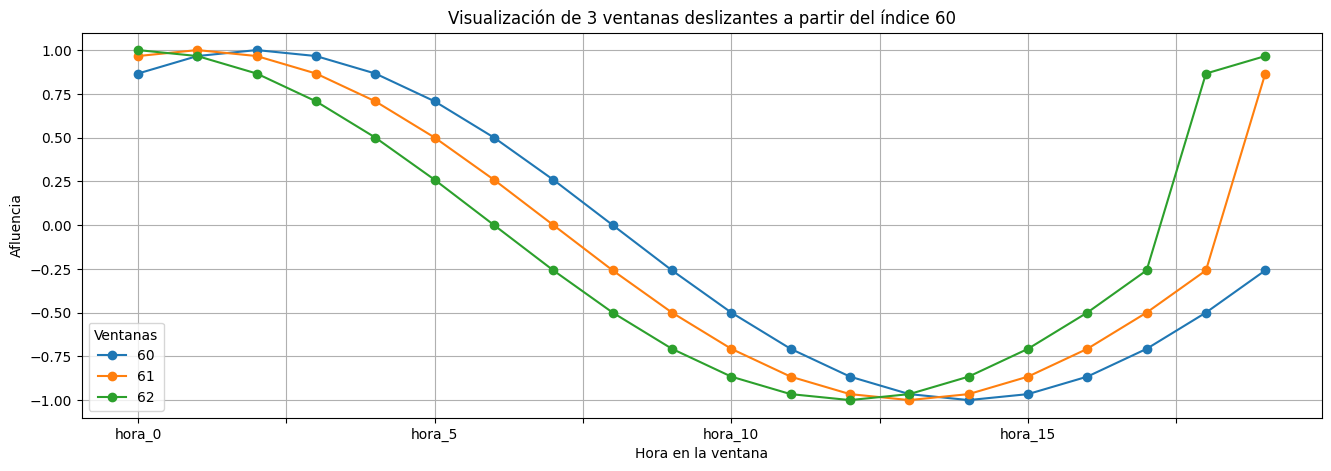

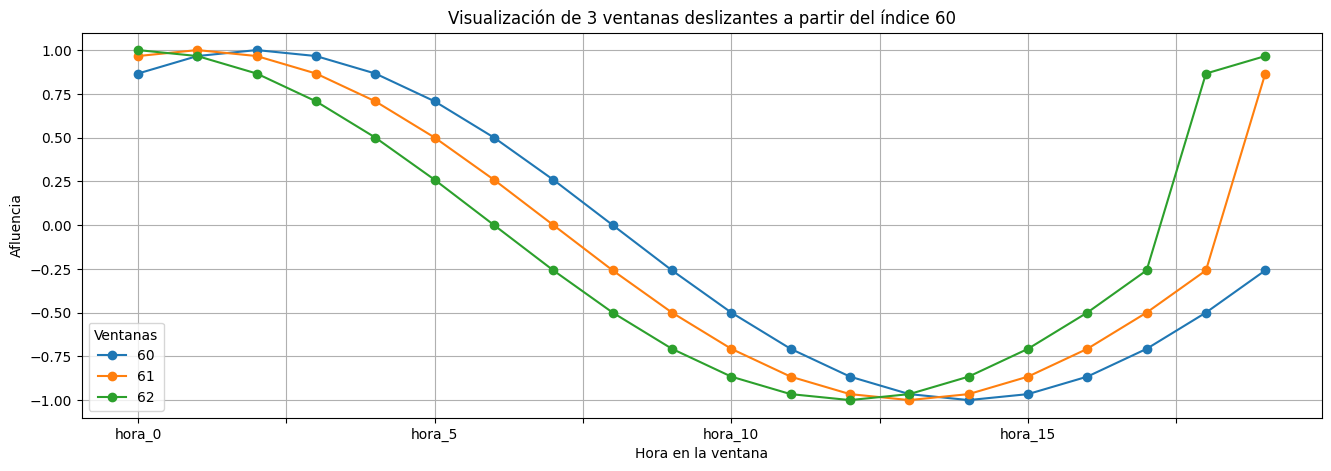

In [696]:
visualizar_ventanas(normales[horas_sin], inicio=((20 * 3)), num_ventanas=3)
visualizar_ventanas(outliers[horas_sin], inicio=((20 * 3)), num_ventanas=3)

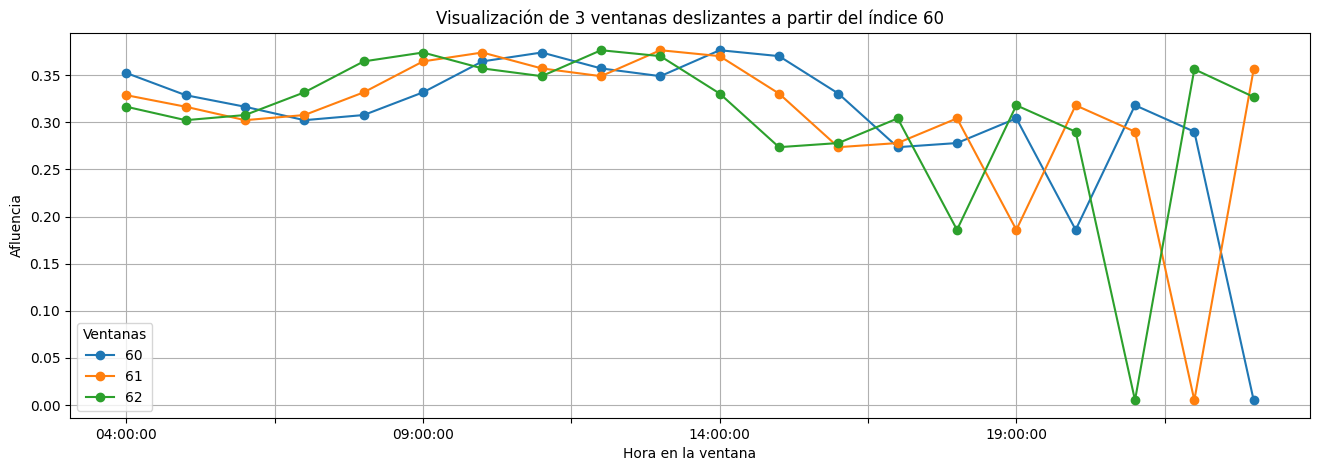

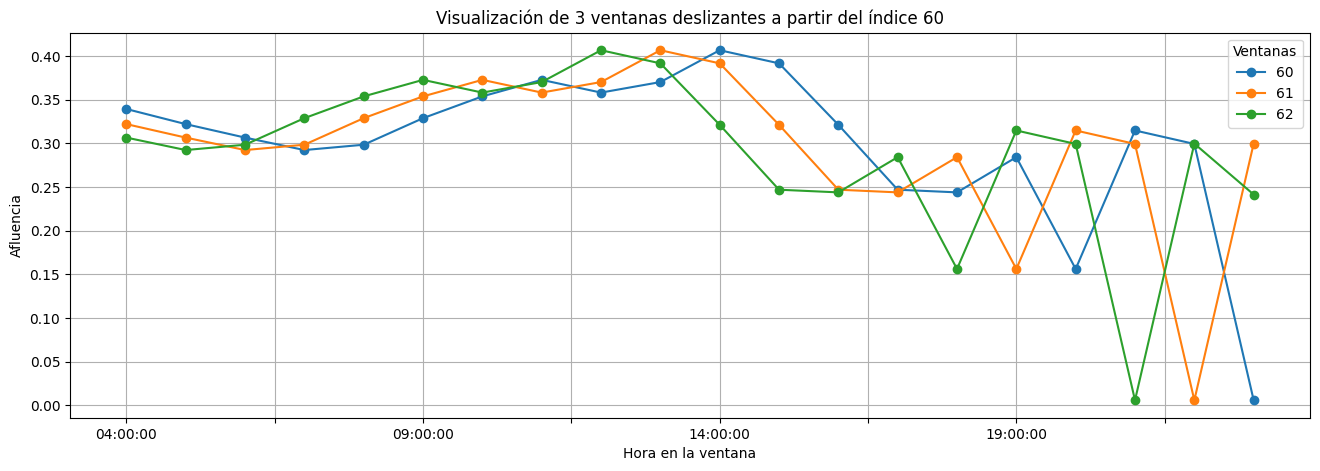

In [697]:
visualizar_ventanas(normales[horas], inicio=((20 * 3)), num_ventanas=3)
visualizar_ventanas(outliers[horas], inicio=((20 * 3)), num_ventanas=3)

In [698]:
# Ya no es necesario escalar los datos, se realizo en el proceso anterior.
train_normales_scaled = train_normales
test_scaled = test
val_scaled = val

# Verificamos el tamaño de los conjuntos escalados
print(f"Train size (normal only, scaled): {train_normales_scaled.shape}")
print(f"Test size (outliers and normal, scaled): {test_scaled.shape}")
print(f"Validation size (outliers and normal, scaled): {val_scaled.shape}")

Train size (normal only, scaled): (13136, 40)
Test size (outliers and normal, scaled): (1642, 40)
Validation size (outliers and normal, scaled): (3422, 41)


In [699]:
train_normales_scaled.shape, test_scaled.shape, val_scaled.shape

((13136, 40), (1642, 40), (3422, 41))

In [700]:
# 11. Entrenar el autoencoder
input_dim = train_normales_scaled[horas].shape[1]
autoencoder, history = entrenar_autoencoder(train_normales_scaled[horas], train_normales_scaled[horas_sin], test_scaled[horas], test_scaled[horas_sin], input_dim)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0780 - val_loss: 0.0659
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0673 - val_loss: 0.0592
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0600 - val_loss: 0.0535
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0543 - val_loss: 0.0485
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0498 - val_loss: 0.0444
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0454 - val_loss: 0.0412
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0423 - val_loss: 0.0387
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 - val_loss: 0.0367
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0375 - val_loss: 0.0350
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - val_loss: 0.0337
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0346 - val_loss: 0.0325
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0

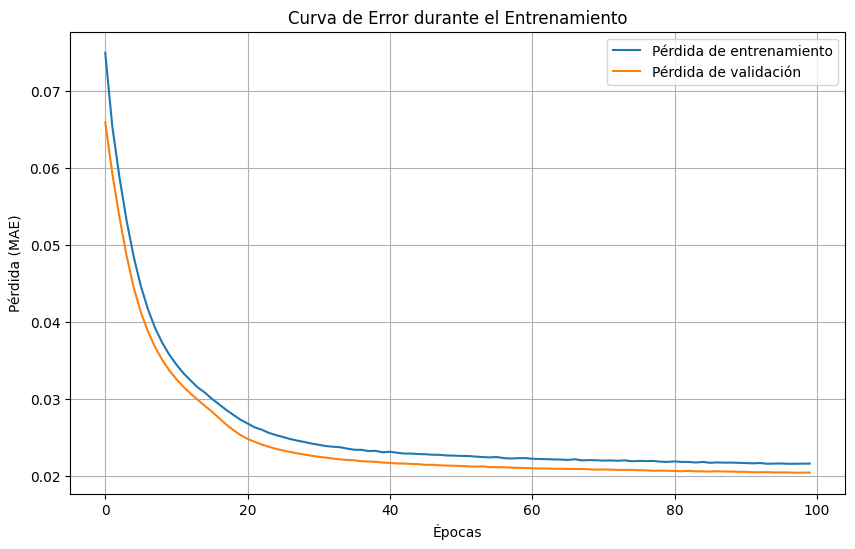

In [701]:
# 12. Graficar la curva de error durante el entrenamiento
graficar_curva_entrenamiento(history)

In [702]:
autoencoder.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 40)        │          0 │ input_layer_38[0… │
│ (Concatenate)       │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 8)         │        328 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 8)         │          0 │ dense_104[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 4)         │         36 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 4)         │          0 │ dense_105[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 4)         │         20 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 4)         │          0 │ dense_106[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 8)         │         40 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 8)         │          0 │ dense_107[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 20)        │        180 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,814 (7.09 KB)

 Trainable params: 604 (2.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,210 (4.73 KB)

In [703]:
val[horas].shape, val[horas_sin].shape

((3422, 20), (3422, 20))

In [704]:
# 13. Evaluar el modelo 
outlier_labels = val['Any_Outlier_outlier'].values
threshold, errors = evaluar_autoencoder(autoencoder, val[horas], val[horas_sin], val[horas], scaler_normales, outlier_labels, umbral=0.5)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [705]:
print(f"El Threshold es: {int(np.round(threshold,0))}")

El Threshold es: 8028


In [706]:
# 14. Calcular las métricas de evaluación con el umbral y mostrar la distribución de errores
predictions = (errors > threshold).astype(int)

accuracy = accuracy_score(outlier_labels, predictions)
precision = precision_score(outlier_labels, predictions)
recall = recall_score(outlier_labels, predictions)
f1 = f1_score(outlier_labels, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.51
Precision: 0.57
Recall: 0.28
F1-Score: 0.37


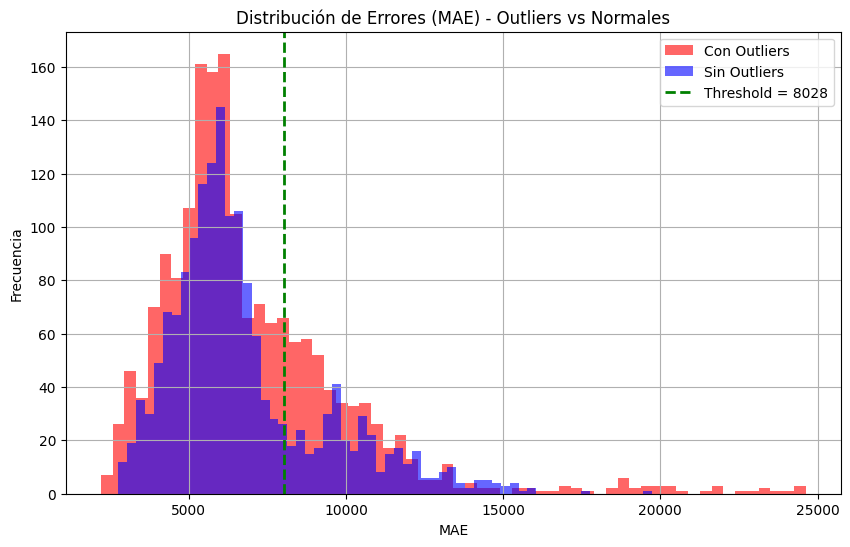

In [707]:
# 15. Graficar la distribución de los errores con el umbral
plt.figure(figsize=(10, 6))
plt.hist(errors[outlier_labels == 1], bins=60, alpha=0.6, label='Con Outliers', color='red')
plt.hist(errors[outlier_labels == 0], bins=60, alpha=0.6, label='Sin Outliers', color='blue')
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold = {threshold:.0f}')
plt.title('Distribución de Errores (MAE) - Outliers vs Normales')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.savefig(f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}_grafico.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


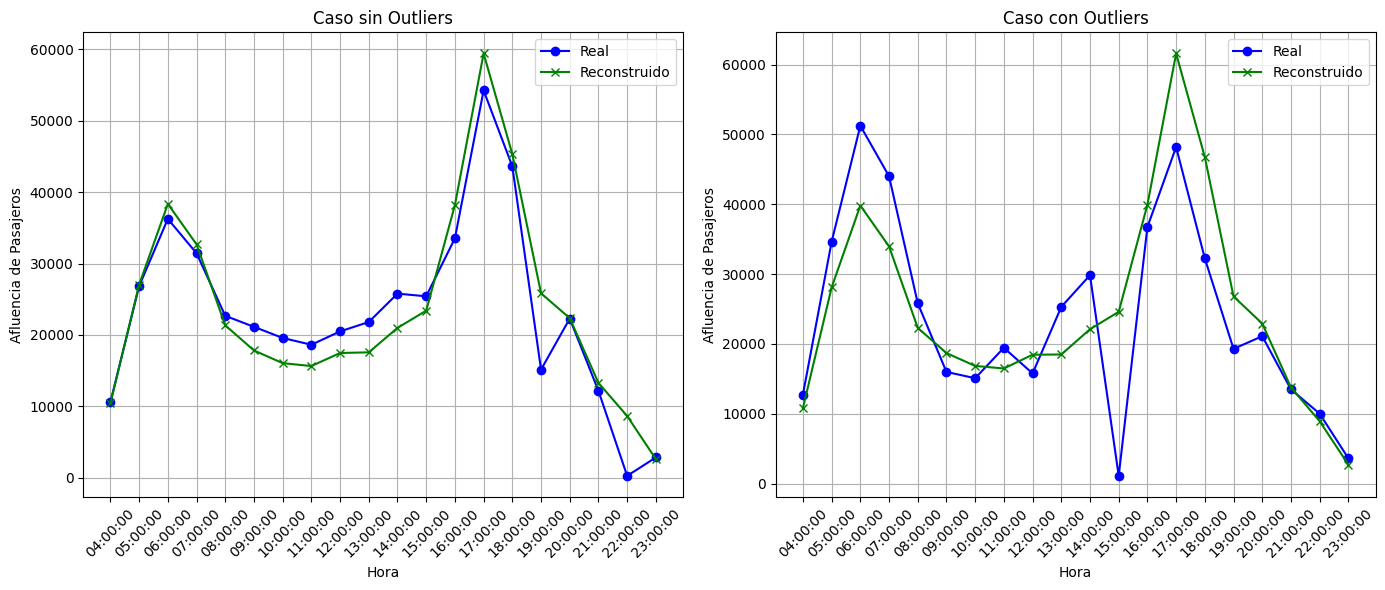

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


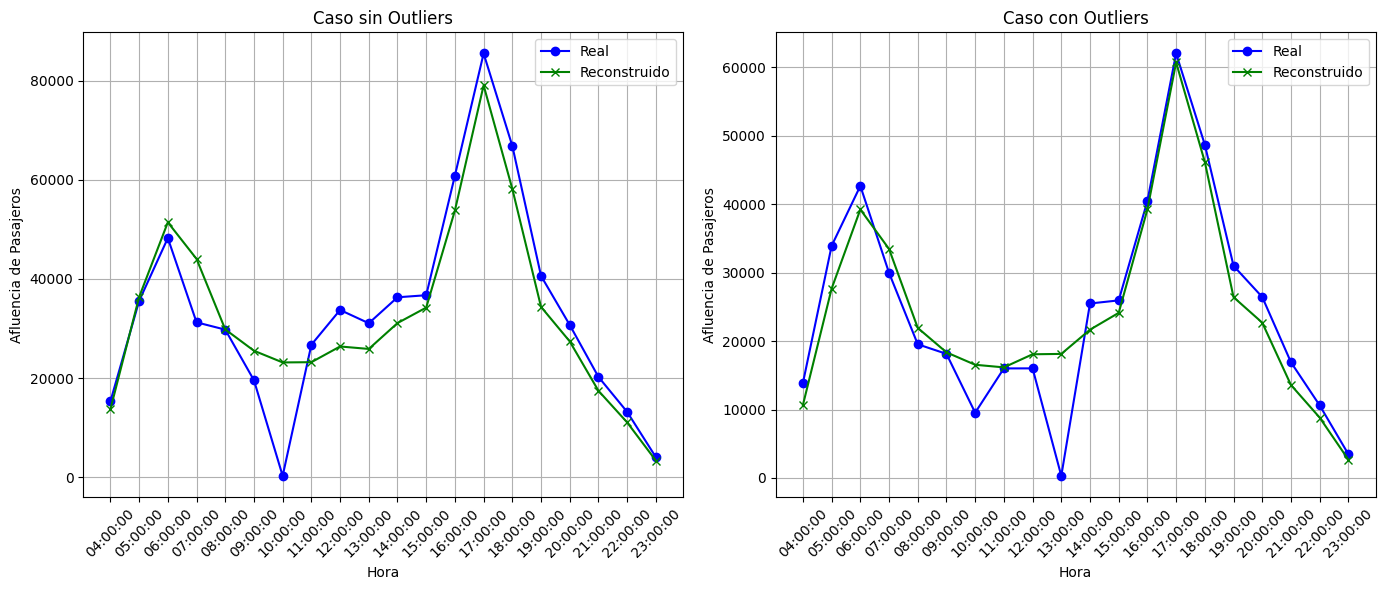

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


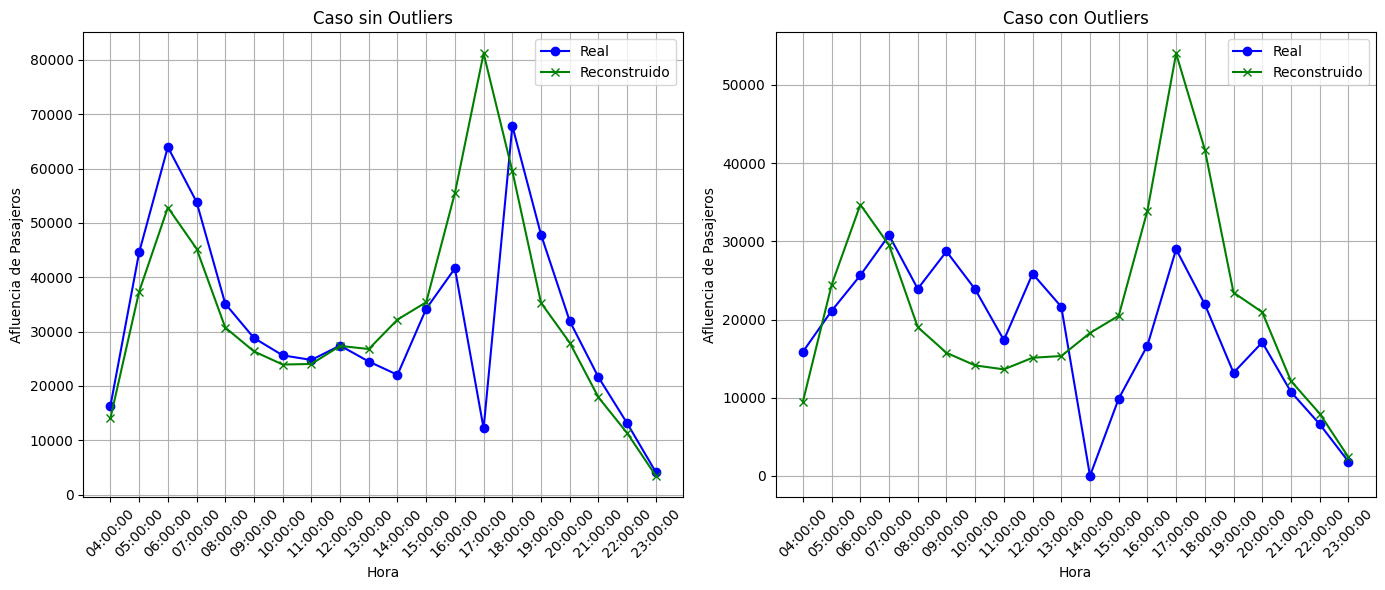

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


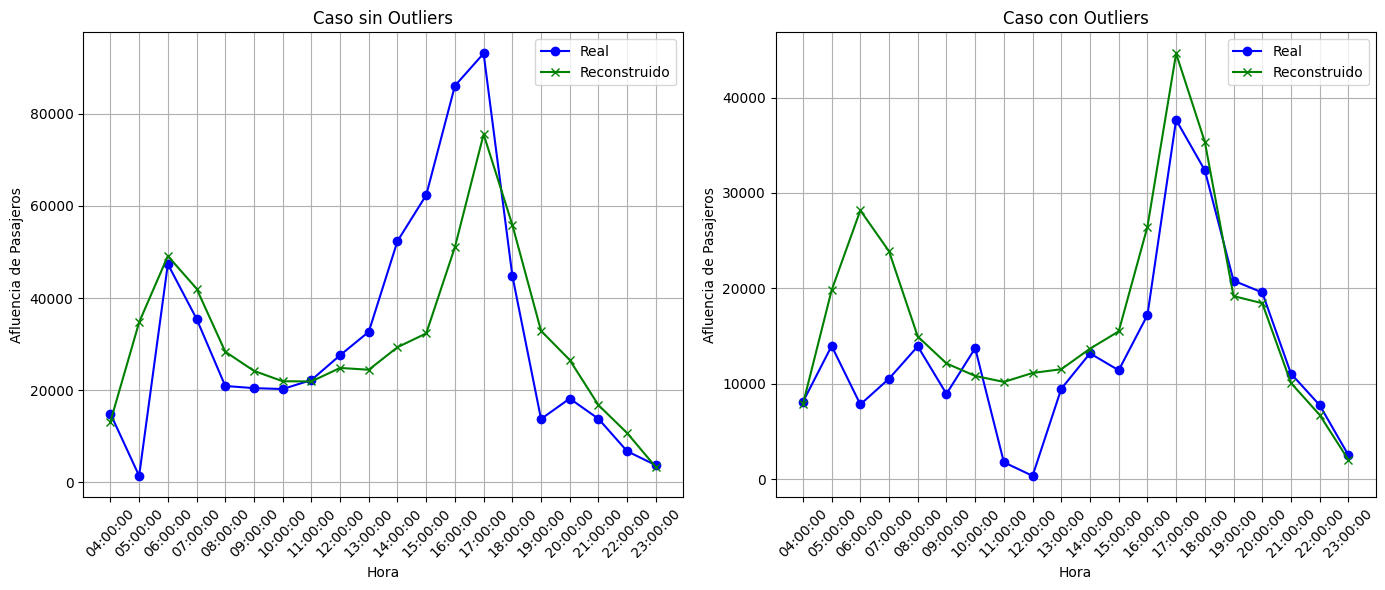

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


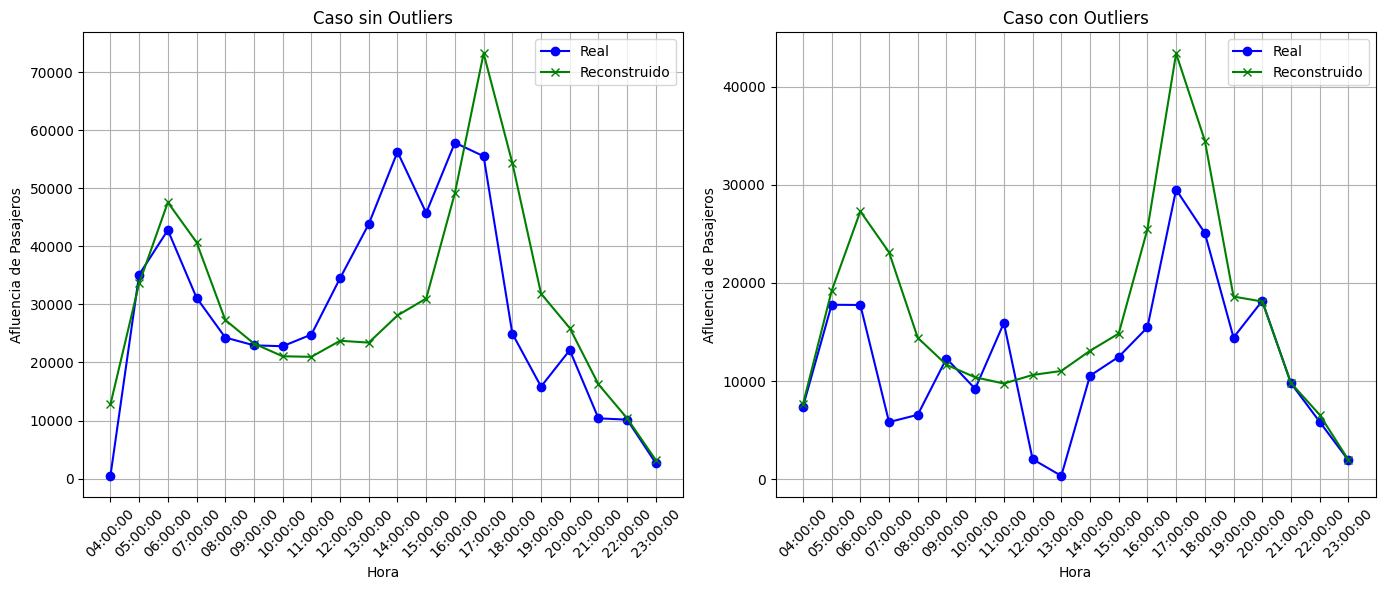

In [716]:
# 16. Visualizar algunas predicciones con y sin outliers
days_to_see = np.random.choice(5, size=5, replace=False)
for day in days_to_see:
    graficar_casos_outliers_vs_normales(autoencoder, scaler_normales, val, horas, horas_sin, n=day)
    plt.show()

In [709]:
# Guardar el modelo completo
autoencoder.save(f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}.h5')
autoencoder.save(f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}.keras')

# Guardar el valor del threshold en un archivo .yml
filename = f'./results/tf_modelo_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}_threshold.yml'
data = {'threshold': int(np.round(threshold,0))}

with open(filename, 'w') as file:
    yaml.dump(data, file)

# Guardar el scaler entrenado en un archivo
scaler_filename = f'./results/scaler_{int(accuracy*100)}_{int(recall*100)}_{int(f1*100)}.pkl'
joblib.dump(scaler_normales, scaler_filename)

['./results/scaler_51_27_37.pkl']

In [710]:
len(horas), len(horas_sin), len(val.columns)

(20, 20, 41)

In [711]:
df_normales_test_val = pd.DataFrame(normales_test_val, columns=val.drop(['Any_Outlier_outlier'], axis=1).columns)
df_outliers_test_val = pd.DataFrame(outliers_test_val, columns=val.drop(['Any_Outlier_outlier'], axis=1).columns)

In [712]:
# TODO: HACE FALTA GUARDAR LAS HORAS SIN
dataset_normales_scaled = scaler_normales.transform(df_normales_test_val[horas])
dataset_outliers_scaled = scaler_normales.transform(df_outliers_test_val[horas])

for idx, registro in enumerate(dataset_normales_scaled):
    dump(registro, open(f'./data_test/x_test_normal_{idx+1}.pkl', 'wb'))

for idx, registro in enumerate(dataset_outliers_scaled):
    dump(registro, open(f'./data_test/x_test_outlier_{idx+1}.pkl', 'wb'))

# FIN
---